# Do not overfit -- Kaggle

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, auc, average_precision_score

In [2]:
data_path = 'data/'
train_data = pd.read_csv(f'{data_path}train.csv', index_col = 'id')
test_data = pd.read_csv(f'{data_path}test.csv', index_col = 'id')

In [3]:
corrs = train_data.drop(labels = ['target'], axis = 1).corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
89690,79,187,0.243916
89691,187,79,0.243916
89692,140,187,0.244012
89693,187,140,0.244012
89694,28,22,0.246062
89695,22,28,0.246062
89696,193,101,0.252825
89697,101,193,0.252825
89698,32,75,0.259315
89699,75,32,0.259315


In [4]:
train_data['target'].value_counts()

1.0    160
0.0     90
Name: target, dtype: int64

In [5]:
columns_impact = pd.DataFrame(
    columns = ['column_name', 'mean_impact_on_0', 'mean_impact_on_1', 'std_0', 'std_1']
)
for col in train_data.columns[train_data.columns != 'target']:
    columns_impact = columns_impact.append(dict(
        column_name = col
        , mean_impact_on_0 = train_data[train_data['target'] == 0][col].mean()
        , mean_impact_on_1 = train_data[train_data['target'] == 1][col].mean()
        , std_0 = train_data[train_data['target'] == 0][col].std()
        , std_1 = train_data[train_data['target'] == 1][col].std()
    )
                                          , ignore_index = True)

In [6]:
columns_impact['difference_of_means'] = (columns_impact['mean_impact_on_0'] - columns_impact['mean_impact_on_1']).abs()
columns_impact['conf_int_gap'] = columns_impact.apply(
    lambda row:
    (row['mean_impact_on_1'] - 2 * row['std_1']) - (row['mean_impact_on_0'] + 2 * row['std_0'])
    if row['mean_impact_on_0'] < row['mean_impact_on_1']
    else (row['mean_impact_on_0'] - 2 * row['std_0']) - (row['mean_impact_on_1'] + 2 * row['std_1'])
    , axis=1
)
best_columns = list(
    columns_impact.sort_values(by=['conf_int_gap', 'difference_of_means']
                               , ascending = [False, False])['column_name'][:100]
)
train_data = train_data[best_columns + ['target']]
train_data.head()

,33,65,82,129,226,245,91,63,182,287,...,81,142,165,98,143,271,6,76,272,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.385,-0.770,-0.380,0.278,0.655,-2.851,0.019,0.933,0.860,-0.284,...,1.292,-0.067,-0.565,-1.556,-0.661,-1.320,-0.236,0.219,-1.516,1.0
1,-2.721,1.221,0.406,1.111,-0.124,-0.187,1.188,1.808,-0.607,0.053,...,-0.661,0.495,0.166,-0.305,-0.822,-2.771,1.172,0.002,-0.516,0.0
2,0.924,0.943,-0.101,0.325,-1.181,0.779,0.269,-0.091,-0.083,1.843,...,-0.031,0.149,-0.729,0.074,-1.661,-0.727,-0.023,1.492,0.346,1.0
3,0.394,-0.706,1.848,-0.630,1.069,1.852,1.103,-0.421,0.855,-0.299,...,0.312,0.614,-0.824,-2.284,-0.268,-0.710,-1.035,0.272,2.725,1.0
4,0.037,0.357,-0.054,-0.062,0.204,-1.096,0.892,0.679,1.775,0.096,...,-0.932,0.472,0.134,0.749,0.949,0.055,0.585,-0.930,-0.464,1.0


f1=0.781 auc=0.932 ap=0.932


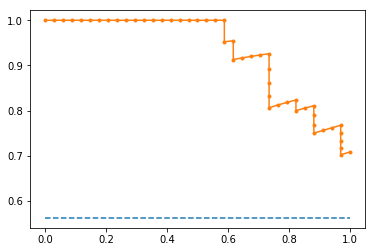

In [7]:
train_X, val_X, train_y, val_y = train_test_split(
    train_data[train_data.columns[train_data.columns != 'target']]
    , train_data['target']
    , random_state = 1
    , test_size = 0.2
)

cl_log = LogisticRegression()
cl_log.fit(train_X, train_y)

probs = cl_log.predict_proba(val_X)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = cl_log.predict(val_X)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(val_y, probs)
# calculate F1 score
f1 = f1_score(val_y, yhat)
# calculate precision-recall AUC
auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(val_y, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
plt.plot([0, 1], [0.5625, 0.5625], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.show()